# TODO

Implementar alguna forma de evasion de peatones por parte de los carros

Agregar un margen a la derecha para ver la leyenda

Make the animation prettier

Modularize (split notebook into more cells)



In [ ]:
!pip install agentpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 2.7 MB/s eta 0:00:00


In [ ]:
import agentpy as ap
import numpy as np
from heapq import heappush, heappop

class Agent(ap.Agent):
    """Base class for all agents in the traffic simulation"""
    def setup(self):
        self.env = self.model.env
        self.current_direction = 0  # 0: right, 1: down, 2: left, 3: up
        self.directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        self.path = []
        self.destination = None
        self.waiting_for_traffic_light = False
        self.moving = True

    def get_position(self):
        pos = self.env.positions[self]
        return (int(pos[0]), int(pos[1]))

    def set_destination(self, dest):
        self.destination = (int(dest[0]), int(dest[1]))
        self.path = self.calculate_path(self.get_position(), self.destination)
        print(f"Calculated path from {self.get_position()} to {self.destination}:")
        print(f"Path: {self.path}")

    def calculate_path(self, start, goal):
        def heuristic(a, b):
            return abs(a[0] - b[0]) + abs(a[1] - b[1])

        def get_neighbors(pos):
            neighbors = []
            for dx, dy in self.directions:
                new_pos = (int(pos[0] + dx), int(pos[1] + dy))
                if (0 <= new_pos[0] < self.env.p.size[0] and
                    0 <= new_pos[1] < self.env.p.size[1]):
                    neighbors.append(new_pos)
            return neighbors

        frontier = []
        heappush(frontier, (0, start))
        came_from = {start: None}
        cost_so_far = {start: 0}

        while frontier:
            current = heappop(frontier)[1]

            if current == goal:
                break

            for next_pos in get_neighbors(current):
                new_cost = cost_so_far[current] + 1
                if next_pos not in cost_so_far or new_cost < cost_so_far[next_pos]:
                    cost_so_far[next_pos] = new_cost
                    priority = new_cost + heuristic(goal, next_pos)
                    heappush(frontier, (priority, next_pos))
                    came_from[next_pos] = current

        path = []
        current = goal
        while current is not None:
            path.append(current)
            current = came_from.get(current)
        path.reverse()
        return path

    def check_traffic_light(self):
        current_pos = self.get_position()
        for light in self.model.traffic_lights:
            if light.get_position() == current_pos:
                return light.state == 'green'
        return True

class Vehicle(Agent):
    """Class representing vehicles in the simulation"""
    def setup(self):
        super().setup()
        self.is_car = True
        self.speed = 1

    def execute(self):
        if not self.moving or not self.path:
            return

        if self.waiting_for_traffic_light:
            if self.check_traffic_light():
                self.waiting_for_traffic_light = False
            else:
                return

        current_pos = self.get_position()
        next_pos = self.path[0]

        # Check for traffic light
        if not self.check_traffic_light():
            self.waiting_for_traffic_light = True
            return

        # Check for other agents
        for agent in self.model.vehicles + self.model.pedestrians:
            if agent != self and agent.get_position() == next_pos:
                return

        # Move to next position
        self.env.move_to(self, next_pos)
        self.path.pop(0)

        # Update direction based on movement
        dx = next_pos[0] - current_pos[0]
        dy = next_pos[1] - current_pos[1]
        for i, (dir_x, dir_y) in enumerate(self.directions):
            if (dx, dy) == (dir_x, dir_y):
                self.current_direction = i
                break

class Pedestrian(Agent):
    """Class representing pedestrians in the simulation"""
    def setup(self):
        super().setup()
        self.is_car = False
        self.speed = 0.5

    def execute(self):
        if not self.moving or not self.path:
            return

        if self.waiting_for_traffic_light:
            if self.check_traffic_light():
                self.waiting_for_traffic_light = False
            else:
                return

        current_pos = self.get_position()
        next_pos = self.path[0]

        # Check for traffic light
        if not self.check_traffic_light():
            self.waiting_for_traffic_light = True
            return

        # Check for other agents
        for agent in self.model.vehicles + self.model.pedestrians:
            if agent != self and agent.get_position() == next_pos:
                return

        # Move to next position
        self.env.move_to(self, next_pos)
        self.path.pop(0)

        # Update direction based on movement
        dx = next_pos[0] - current_pos[0]
        dy = next_pos[1] - current_pos[1]
        for i, (dir_x, dir_y) in enumerate(self.directions):
            if (dx, dy) == (dir_x, dir_y):
                self.current_direction = i
                break

class TrafficLight(ap.Agent):
    """Class representing traffic lights in the simulation"""
    def setup(self):
        self.env = self.model.env
        self.state = 'red'
        self.tiempo = 0
        self.cycle_duration = 30  # Duration of each traffic light state

    def get_position(self):
        pos = self.env.positions[self]
        return (int(pos[0]), int(pos[1]))

    def execute(self):
        self.tiempo += 1
        if self.tiempo >= self.cycle_duration:
            self.cambiar_color()
            self.tiempo = 0

    def cambiar_color(self):
        if self.state == 'red':
            self.state = 'green'
        elif self.state == 'green':
            self.state = 'yellow'
        else:
            self.state = 'red'

class TrafficModel(ap.Model):
    """Main model class for the traffic simulation"""
    def __init__(self, parameters):
        super().__init__(parameters)
        self.p = parameters
        self.setup()

class TrafficModel(ap.Model):
    def __init__(self, parameters):
        super().__init__(parameters)
        # Initialize attributes explicitly
        self.traffic_lights = []
        self.vehicles = []
        self.pedestrians = []
        self.size = parameters['size']
        self.traffic_light_positions = parameters['traffic_light_positions']
        self.vehicle_data = parameters['vehicles']
        self.pedestrian_data = parameters['pedestrians']
        # Initialize time step
        self.t = 0
        # Now call setup
        self.setup()

    def setup(self):
        """Initialize the model"""
        print("Setting up model...")

        # Create the environment grid
        print(f"Creating grid with size {self.size}")
        self.env = ap.Grid(self, shape=self.size)

        # Create traffic lights
        print("Creating traffic lights...")
        for pos in self.traffic_light_positions:
            pos = (int(pos[0]), int(pos[1]))
            light = TrafficLight(self)
            self.traffic_lights.append(light)
            self.env.add_agents([light], positions=[pos])
            print(f"Added traffic light at position {pos}")

        # Create vehicles
        print("Creating vehicles...")
        for v in self.vehicle_data:
            start_pos = (int(v['start_pos'][0]), int(v['start_pos'][1]))
            dest = (int(v['destination'][0]), int(v['destination'][1]))
            vehicle = Vehicle(self)
            self.vehicles.append(vehicle)
            self.env.add_agents([vehicle], positions=[start_pos])
            vehicle.set_destination(dest)
            print(f"Added vehicle from {start_pos} to {dest}")

        # Create pedestrians
        print("Creating pedestrians...")
        for p in self.pedestrian_data:
            start_pos = (int(p['start_pos'][0]), int(p['start_pos'][1]))
            dest = (int(p['destination'][0]), int(p['destination'][1]))
            pedestrian = Pedestrian(self)
            self.pedestrians.append(pedestrian)
            self.env.add_agents([pedestrian], positions=[start_pos])
            pedestrian.set_destination(dest)
            print(f"Added pedestrian from {start_pos} to {dest}")

        print("Model setup complete!")

    def step(self):
        """Execute one step of the simulation"""
        print(f"\nStep {self.t}: Processing...")

        # Execute traffic lights
        for light in self.traffic_lights:
            light.execute()

        # Execute vehicles
        for vehicle in self.vehicles:
            pos = vehicle.get_position()
            print(f"Vehicle at position: {pos}")
            vehicle.execute()

        # Execute pedestrians
        for pedestrian in self.pedestrians:
            pos = pedestrian.get_position()
            print(f"Pedestrian at position: {pos}")
            pedestrian.execute()

        self.t += 1
        print(f"Step {self.t-1}: Complete\n")

    def end(self):
        """Check if simulation should end"""
        print("Checking end conditions...")
        all_agents_arrived = all(not vehicle.path for vehicle in self.vehicles) and \
                           all(not pedestrian.path for pedestrian in self.pedestrians)
        if all_agents_arrived:
            print("All agents have arrived at their destinations!")
            return True
        return False

# Example parameters for using the model:
parameters = {
    'size': (10, 10),
    'traffic_light_positions': [(5, 5)],
    'vehicles': [
        {
            'start_pos': (1, 1),
            'destination': (8, 8)
        }
    ],
    'pedestrians': [
        {
            'start_pos': (1, 8),
            'destination': (8, 1)
        },
        {
            'start_pos': (8, 8),
            'destination': (1, 1)
        }
    ],
    'steps': 100
}

Creating model...
AgentPy version: 0.1.5
Setting up model...
Creating grid with size (10, 10)
Creating traffic lights...
Added traffic light at position (5, 5)
Creating vehicles...
Calculated path from (1, 1) to (8, 8):
Path: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (2, 8), (3, 8), (4, 8), (5, 8), (6, 8), (7, 8), (8, 8)]
Added vehicle from (1, 1) to (8, 8)
Creating pedestrians...
Calculated path from (1, 8) to (8, 1):
Path: [(1, 8), (1, 7), (1, 6), (1, 5), (1, 4), (1, 3), (1, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]
Added pedestrian from (1, 8) to (8, 1)
Calculated path from (8, 8) to (1, 1):
Path: [(8, 8), (7, 8), (6, 8), (5, 8), (4, 8), (3, 8), (2, 8), (1, 8), (1, 7), (1, 6), (1, 5), (1, 4), (1, 3), (1, 2), (1, 1)]
Added pedestrian from (8, 8) to (1, 1)
Model setup complete!
Running simulation...
Step 0 recorded

Step 0: Processing...
Vehicle at position: (1, 1)
Pedestrian at position: (1, 8)
Pedestrian at position: (8, 8)
Step 0: Co

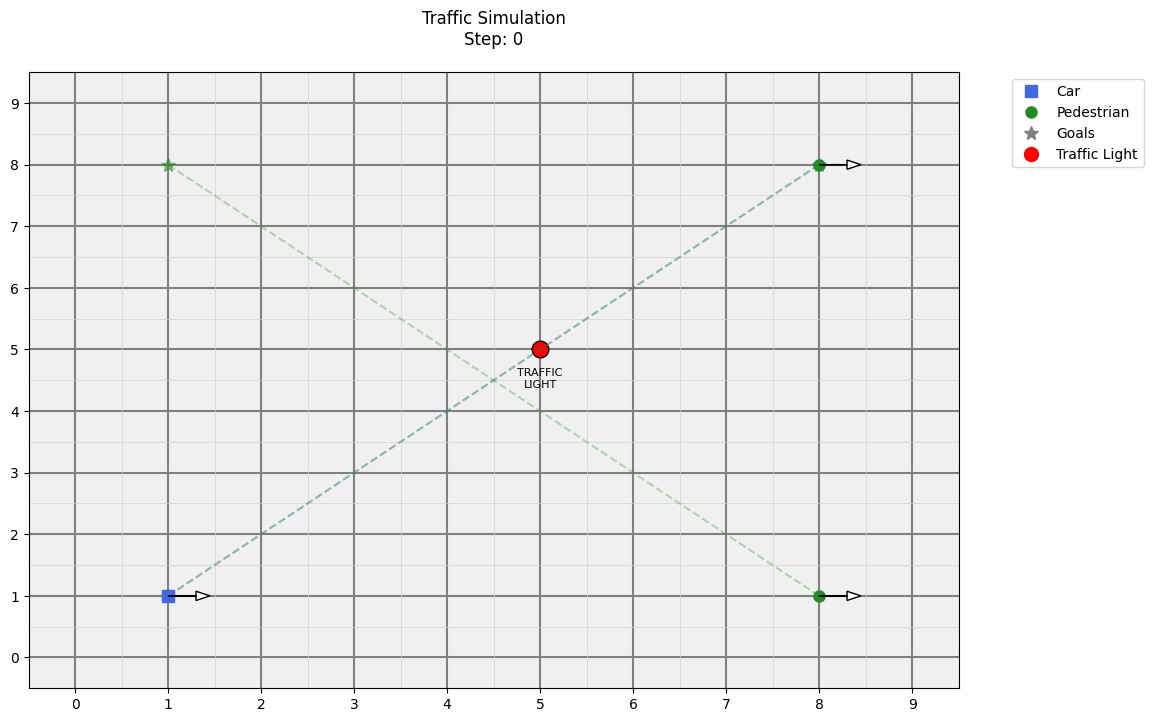

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as animation
import agentpy as ap

# Define parameters as a regular dictionary
parameters = {
    'size': (10, 10),
    'traffic_light_positions': [(5, 5)],
    'vehicles': [
        {
            'start_pos': (1, 1),
            'destination': (8, 8)
        }
    ],
    'pedestrians': [
        {
            'start_pos': (1, 8),
            'destination': (8, 1)
        },
        {
            'start_pos': (8, 8),
            'destination': (1, 1)
        }
    ],
    'steps': 100
}

# Create and initialize the model
print("Creating model...")
print(f"AgentPy version: {ap.__version__}")
model = TrafficModel(parameters)

# Create a list to store states
states = []

# Run simulation and collect states
print("Running simulation...")
for step in range(parameters['steps']):
    # Record current state
    state = {
        't': model.t,
        'traffic_lights': [],
        'vehicles': [],
        'pedestrians': []
    }

    # Record traffic light states
    for light in model.traffic_lights:
        state['traffic_lights'].append((light.get_position(), light.state))

    # Record vehicle states
    for vehicle in model.vehicles:
        state['vehicles'].append((
            vehicle.get_position(),
            vehicle.current_direction,
            vehicle.destination
        ))

    # Record pedestrian states
    for ped in model.pedestrians:
        state['pedestrians'].append((
            ped.get_position(),
            ped.current_direction,
            ped.destination
        ))

    states.append(state)
    print(f"Step {step} recorded")

    # Step the model forward
    model.step()

print("Simulation complete. Creating animation...")

# Create figure and axis for animation
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

def update(frame_num):
    ax.clear()
    state = states[frame_num]

    # Create background grid for streets
    for i in range(parameters['size'][0] + 1):
        ax.axhline(y=i-0.5, color='lightgray', linestyle='-', linewidth=0.5)
        ax.axvline(x=i-0.5, color='lightgray', linestyle='-', linewidth=0.5)

    # Fill street blocks with light color
    for i in range(parameters['size'][0]):
        for j in range(parameters['size'][1]):
            ax.fill([j-0.5, j+0.5, j+0.5, j-0.5],
                   [i-0.5, i-0.5, i+0.5, i+0.5],
                   color='#f0f0f0')

    # Plot traffic lights
    for pos, light_state in state['traffic_lights']:
        color = {'red': 'red', 'yellow': 'yellow', 'green': 'green'}[light_state]
        ax.plot(pos[1], pos[0], 'o', color='black', markersize=12)
        ax.plot(pos[1], pos[0], 'o', color=color, markersize=10)
        ax.text(pos[1], pos[0]-0.3, 'TRAFFIC\nLIGHT', ha='center', va='top', fontsize=8)

    # Plot vehicles
    for pos, direction, dest in state['vehicles']:
        # Plot vehicle
        ax.plot(pos[1], pos[0], 's', color='royalblue', markersize=8, zorder=3)
        # Plot goal
        ax.plot(dest[1], dest[0], '*', color='royalblue', markersize=10, alpha=0.5)
        # Draw line to goal
        ax.plot([pos[1], dest[1]], [pos[0], dest[0]], '--', color='royalblue', alpha=0.3)
        # Draw direction indicator
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        dir_vec = directions[direction]
        ax.arrow(pos[1], pos[0],
                dir_vec[1]*0.3, dir_vec[0]*0.3,
                head_width=0.15, head_length=0.15,
                fc='white', ec='black', zorder=4)

    # Plot pedestrians
    for pos, direction, dest in state['pedestrians']:
        # Plot pedestrian
        ax.plot(pos[1], pos[0], 'o', color='forestgreen', markersize=8, zorder=3)
        # Plot goal
        ax.plot(dest[1], dest[0], '*', color='forestgreen', markersize=10, alpha=0.5)
        # Draw line to goal
        ax.plot([pos[1], dest[1]], [pos[0], dest[0]], '--', color='forestgreen', alpha=0.3)
        # Draw direction indicator
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        dir_vec = directions[direction]
        ax.arrow(pos[1], pos[0],
                dir_vec[1]*0.3, dir_vec[0]*0.3,
                head_width=0.15, head_length=0.15,
                fc='white', ec='black', zorder=4)

    # Enhanced grid and layout
    ax.grid(True, which='major', color='gray', linewidth=1.5)
    ax.set_xlim(-0.5, parameters['size'][1] - 0.5)
    ax.set_ylim(-0.5, parameters['size'][0] - 0.5)
    ax.set_xticks(range(parameters['size'][1]))
    ax.set_yticks(range(parameters['size'][0]))
    ax.set_title(f"Traffic Simulation\nStep: {state['t']}", pad=20)

    # Add legend
    ax.plot([], [], 's', color='royalblue', markersize=8, label='Car')
    ax.plot([], [], 'o', color='forestgreen', markersize=8, label='Pedestrian')
    ax.plot([], [], '*', color='gray', markersize=10, label='Goals')
    ax.plot([], [], 'o', color='red', markersize=10, label='Traffic Light')
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

    return ax,

print("Creating animation...")
# Create animation
anim = animation.FuncAnimation(
    fig,
    update,
    frames=len(states),
    interval=200,  # milliseconds between frames
    blit=False,
    repeat=True
)

# Display the animation
HTML(anim.to_jshtml())